Load MNIST data from tensor flow tutorial

In [1]:
# TODO: Need to update data download with new methods
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

# Print image data set parameters
print('Input Image shape: ', X_train[0].shape)
print("No. of training images: ", len(X_train))
print("No. of validation images: ", len(X_validation))
print("No. of testing images: ", len(X_test))


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Input Image shape:  (28, 28, 1)
No. of training images:  55000
No. of validation images:  5000
No. of testing images:  10000


Pre-processing images (need to resize 28x28 to 32x32 to be compatable with LeNet

In [2]:
import numpy as np
# Pad images with 0s
X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

print("Updated image size:", X_train[0].shape)


Updated image size: (32, 32, 1)


Visualize input images

In [3]:
import random
import matplotlib.pyplot as plt
# select a random image
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
# plot the images
plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

# pre-processing 
#from sklearn.utils import shuffle
#X_train, y_train = shuffle(X_train, y_train)

1


Visualize Data

6


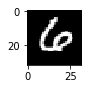

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

Implement LeNet in tensorflow

In [5]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_kernel = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_bias   = tf.Variable(tf.zeros(6))
    conv1_output = tf.nn.conv2d(x, conv1_kernel, strides=[1, 1, 1, 1], padding='VALID') + conv1_bias

    # Layer 1: Activation.
    conv1_output = tf.nn.relu(conv1_output)

    # Layer 1: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1_output = tf.nn.max_pool(conv1_output, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_kernel = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_bias   = tf.Variable(tf.zeros(16))
    conv2_output = tf.nn.conv2d(conv1_output, conv2_kernel, strides=[1, 1, 1, 1], padding='VALID') + conv2_bias
    
    # Layer 2: Activation.
    conv2_output = tf.nn.relu(conv2_output)

    # Layer 2: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2_output = tf.nn.max_pool(conv2_output, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 3: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2_output)
    
    # Layer 4: Fully Connected. Input = 400. Output = 120.
    fc1_kernel = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_bias   = tf.Variable(tf.zeros(120))
    fc1_output = tf.matmul(fc0, fc1_kernel) + fc1_bias
    
    # Layer 4: Activation.
    fc1_output = tf.nn.relu(fc1_output)

    # Layer 5: Fully Connected. Input = 120. Output = 84.
    fc2_kernel = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_bias   = tf.Variable(tf.zeros(84))
    fc2_output = tf.matmul(fc1_output, fc2_kernel) + fc2_bias
    
    # Layer 5: Activation.
    fc2_output = tf.nn.relu(fc2_output)

    # Layer 6: Fully Connected. Input = 84. Output = 10.
    fc3_kernel = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
    fc3_bias   = tf.Variable(tf.zeros(10))
    logits     = tf.matmul(fc2_output, fc3_kernel) + fc3_bias
    
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)


Setup training pipeline

In [7]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Setup model evaluation pipeline

In [8]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Train the model

Note: Saves four files
    1. checkpoint : 
    2. lenet.data-0000-of-00001 : holding weights
    3. lenet.index
    4. lenet.meta : graph meta data for re-training

In [26]:
from pathlib import Path

EPOCHS = 1
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    model_file = Path("model/LeNet.ckpt.meta")
    if model_file.is_file():
        saver.restore(sess, 'model/LeNet.ckpt')
        print("Loaded model from disk")
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        # X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'model/LeNet.ckpt')
    tf.train.write_graph(sess.graph.as_graph_def(), '.', 'model/LeNet.pbtxt', as_text=True)
    tf.train.write_graph(sess.graph.as_graph_def(), '.', 'model/LeNet.pb', as_text=False)
    print("Model saved")

model\LeNet.ckpt.meta
True
INFO:tensorflow:Restoring parameters from model/LeNet.ckpt
Loaded model from disk
Training...

EPOCH 1 ...
Validation Accuracy = 0.978

Model saved


save, restore and evaluate the model

In [28]:
with tf.Session() as sess:
    saver.restore(sess, 'model/LeNet.ckpt')
    #new_saver = tf.train.import_meta_graph('model/AlexNet.meta')
    #new_saver.restore(sess, tf.train.latest_checkpoint('model/'))
                
    validation_accuracy = evaluate(X_validation, y_validation)
    print("EPOCH {} ...".format(i+1))
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    print()
    
    saver.save(sess, 'model/LeNet.ckpt')
    tf.train.write_graph(sess.graph.as_graph_def(), '.', 'model/LeNet.pbtxt', as_text=True)
    tf.train.write_graph(sess.graph.as_graph_def(), '.', 'model/LeNet.pb', as_text=False)
    
print("Model saved")

INFO:tensorflow:Restoring parameters from model/LeNet.ckpt
EPOCH 1 ...
Validation Accuracy = 0.978

Model saved


Evaluate the model

In [11]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.986


Saving the model as froozen graph
Step 1: 

In [4]:
import tensorflow as tf
with tf.Session(graph=tf.Graph()) as sess:
    # importing the meta data from saved graph
    saver = tf.train.import_meta_graph('lenet.meta', clear_devices=True)
    # restore weights
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    # export variables to constants using built-in TF helper
    output_graph_def = tf.graph_util.convert_variables_to_constants(
                       sess,          # session used to retrieve weights
                       tf.get_default_graph().as_graph_def(), # graph_def used to retrieve nodes
                       output_node_names.split(",")) # output node names are used to select the usefull nodes
    
    # serialize and dump graph into file system
    with tf.gfile.GFile(output_graph, "wb") as f:
        f.write(output_graph_def.SerializeToString())
    print("%d ops in the final graph." % len(output_graph_def.node))
    
    

.\lenet
